## Assignment 3: Graph Neural Networks



In [13]:
import os
import torch
print(torch.__version__)
print(torch.version.cuda)

2.3.1
11.8


https://drive.google.com/drive/folders/11uuYl0peqPg2DQno64YPYMODPu8fjDXU

In [14]:
!pip install torch_geometric

# Optional dependencies:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.3.0+cu118.html

Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu118.html


In [43]:
DATASET_NAME = "WaterDropSmall"
OUTPUT_DIR = os.path.join("./", DATASET_NAME)

In [44]:
import os
import json
import numpy as np
import torch
import torch_geometric as pyg


class RolloutDataset(pyg.data.Dataset):
    def __init__(self, data_path, split, window_length=7):
        super().__init__()

        # load data from the disk
        with open(os.path.join(data_path, "metadata.json")) as f:
            self.metadata = json.load(f)
        with open(os.path.join(data_path, f"{split}_offset.json")) as f:
            self.offset = json.load(f)
        self.offset = {int(k): v for k, v in self.offset.items()}
        self.window_length = window_length

        self.particle_type = np.memmap(os.path.join(data_path, f"{split}_particle_type.dat"), dtype=np.int64, mode="r")
        self.position = np.memmap(os.path.join(data_path, f"{split}_position.dat"), dtype=np.float32, mode="r")

        for traj in self.offset.values():
            self.dim = traj["position"]["shape"][2]
            break

    def len(self):
        return len(self.offset)

    def get(self, idx):
        traj = self.offset[idx]
        size = traj["position"]["shape"][1]
        time_step = traj["position"]["shape"][0]
        particle_type = self.particle_type[traj["particle_type"]["offset"]: traj["particle_type"]["offset"] + size].copy()
        particle_type = torch.from_numpy(particle_type)
        position = self.position[traj["position"]["offset"]: traj["position"]["offset"] + time_step * size * self.dim].copy()
        position.resize(traj["position"]["shape"])
        position = torch.from_numpy(position)
        data = {"particle_type": particle_type, "position": position}
        return data


## Data Selection and Graph Analysis (Tasks 1 and 2)

### data sampling

In [17]:
import json
import numpy as np
import torch_geometric as pyg

def generate_noise(position_seq, noise_std):
    """Generate noise for a trajectory"""
    velocity_seq = position_seq[:, 1:] - position_seq[:, :-1]
    time_steps = velocity_seq.size(1)
    velocity_noise = torch.randn_like(velocity_seq) * (noise_std / time_steps ** 0.5)
    velocity_noise = velocity_noise.cumsum(dim=1)
    position_noise = velocity_noise.cumsum(dim=1)
    position_noise = torch.cat((torch.zeros_like(position_noise)[:, 0:1], position_noise), dim=1)
    return position_noise


def preprocess(particle_type, position_seq, target_position, metadata, noise_std):
    """Preprocess a trajectory and construct the graph"""
    # apply noise to the trajectory
    position_noise = generate_noise(position_seq, noise_std)
    position_seq = position_seq + position_noise

    # calculate the velocities of particles
    recent_position = position_seq[:, -1]
    velocity_seq = position_seq[:, 1:] - position_seq[:, :-1]

    # construct the graph based on the distances between particles
    n_particle = recent_position.size(0)
    edge_index = pyg.nn.radius_graph(recent_position, metadata["default_connectivity_radius"], loop=True, max_num_neighbors=n_particle)

    # node-level features: velocity, distance to the boundary
    normal_velocity_seq = (velocity_seq - torch.tensor(metadata["vel_mean"])) / torch.sqrt(torch.tensor(metadata["vel_std"]) ** 2 + noise_std ** 2)
    boundary = torch.tensor(metadata["bounds"])
    distance_to_lower_boundary = recent_position - boundary[:, 0]
    distance_to_upper_boundary = boundary[:, 1] - recent_position
    distance_to_boundary = torch.cat((distance_to_lower_boundary, distance_to_upper_boundary), dim=-1)
    distance_to_boundary = torch.clip(distance_to_boundary / metadata["default_connectivity_radius"], -1.0, 1.0)

    # edge-level features: displacement, distance
    dim = recent_position.size(-1)
    edge_displacement = (torch.gather(recent_position, dim=0, index=edge_index[0].unsqueeze(-1).expand(-1, dim)) -
                   torch.gather(recent_position, dim=0, index=edge_index[1].unsqueeze(-1).expand(-1, dim)))
    edge_displacement /= metadata["default_connectivity_radius"]
    edge_distance = torch.norm(edge_displacement, dim=-1, keepdim=True)

    # ground truth for training
    if target_position is not None:
        last_velocity = velocity_seq[:, -1]
        next_velocity = target_position + position_noise[:, -1] - recent_position
        acceleration = next_velocity - last_velocity
        acceleration = (acceleration - torch.tensor(metadata["acc_mean"])) / torch.sqrt(torch.tensor(metadata["acc_std"]) ** 2 + noise_std ** 2)
    else:
        acceleration = None

    # return the graph with features
    graph = pyg.data.Data(
        x=particle_type,
        edge_index=edge_index,
        edge_attr=torch.cat((edge_displacement, edge_distance), dim=-1),
        y=acceleration,
        pos=torch.cat((velocity_seq.reshape(velocity_seq.size(0), -1), distance_to_boundary), dim=-1)
    )
    return graph

In [18]:
class OneStepDataset(pyg.data.Dataset):
    def __init__(self, data_path, split, window_length=7, noise_std=0.0, return_pos=False):
        super().__init__()

        # load dataset from the disk
        with open(os.path.join(data_path, "metadata.json")) as f:
            self.metadata = json.load(f)
        with open(os.path.join(data_path, f"{split}_offset.json")) as f:
            self.offset = json.load(f)
        self.offset = {int(k): v for k, v in self.offset.items()}
        self.window_length = window_length
        self.noise_std = noise_std
        self.return_pos = return_pos

        self.particle_type = np.memmap(os.path.join(data_path, f"{split}_particle_type.dat"), dtype=np.int64, mode="r")
        self.position = np.memmap(os.path.join(data_path, f"{split}_position.dat"), dtype=np.float32, mode="r")

        for traj in self.offset.values():
            self.dim = traj["position"]["shape"][2]
            break

        # cut particle trajectories according to time slices
        self.windows = []
        for traj in self.offset.values():
            size = traj["position"]["shape"][1]
            length = traj["position"]["shape"][0] - window_length + 1
            for i in range(length):
                desc = {
                    "size": size,
                    "type": traj["particle_type"]["offset"],
                    "pos": traj["position"]["offset"] + i * size * self.dim,
                }
                self.windows.append(desc)

    def len(self):
        return len(self.windows)

    def get(self, idx):
        # load corresponding data for this time slice
        window = self.windows[idx]
        size = window["size"]
        particle_type = self.particle_type[window["type"]: window["type"] + size].copy()
        particle_type = torch.from_numpy(particle_type)
        position_seq = self.position[window["pos"]: window["pos"] + self.window_length * size * self.dim].copy()
        position_seq.resize(self.window_length, size, self.dim)
        position_seq = position_seq.transpose(1, 0, 2)
        target_position = position_seq[:, -1]
        position_seq = position_seq[:, :-1]
        target_position = torch.from_numpy(target_position)
        position_seq = torch.from_numpy(position_seq)

        # construct the graph
        with torch.no_grad():
            graph = preprocess(particle_type, position_seq, target_position, self.metadata, self.noise_std)
        if self.return_pos:
          return graph, position_seq[:, -1]
        return graph

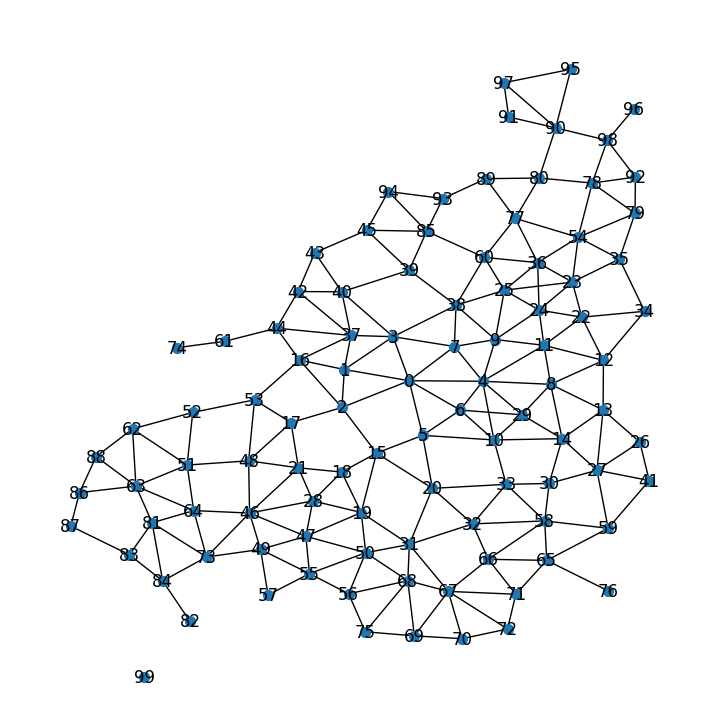

Data(x=[100], edge_index=[2, 222], y=[100, 2], pos=[100, 14])


In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch_geometric as pyg
from torch_geometric.data import Data
import numpy as np
import pandas as pd

# Load the dataset
dataset_sample = OneStepDataset(OUTPUT_DIR, "valid", return_pos=True)
graph, position = dataset_sample[0]




# Convert to NetworkX graph for visualization
G = nx.Graph()
edge_index = graph.edge_index.numpy()

# Add edges to the NetworkX graph
G.add_edges_from(edge_index.T)

# Remove self loops
G.remove_edges_from(nx.selfloop_edges(G))

# Sample a small subset (optional)
# For demonstration, we'll use the first 100 nodes if the dataset is large
num_nodes = min(G.number_of_nodes(), 100)
sampled_graph = G.subgraph(range(num_nodes))
sampled_positions = position[:num_nodes]

# Plot the sampled graph
plt.figure(figsize=(7, 7))
nx.draw(sampled_graph, pos={i: tuple(v) for i, v in enumerate(sampled_positions)}, node_size=50, with_labels=True)
plt.show()

# Convert the sampled NetworkX graph back to torch_geometric Data format
# Get the edges and features of the subgraph
sampled_edges = np.array(sampled_graph.edges).T
sampled_edge_index = torch.tensor(sampled_edges, dtype=torch.long)

# Extract node features for the sampled nodes
sampled_nodes = list(sampled_graph.nodes)
sampled_x = graph.x[sampled_nodes]
sampled_pos = graph.pos[sampled_nodes]
sampled_y = graph.y[sampled_nodes]

# Create a torch_geometric.data.Data object for the sampled graph
sampled_data = Data(x=sampled_x, edge_index=sampled_edge_index, pos=sampled_pos, y=sampled_y)

print(sampled_data)


Graph is undirected.


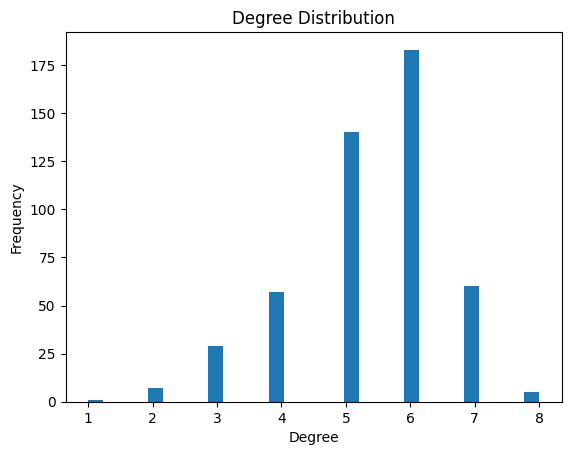

Graph has no loops.
Graph has 0 isolated nodes.


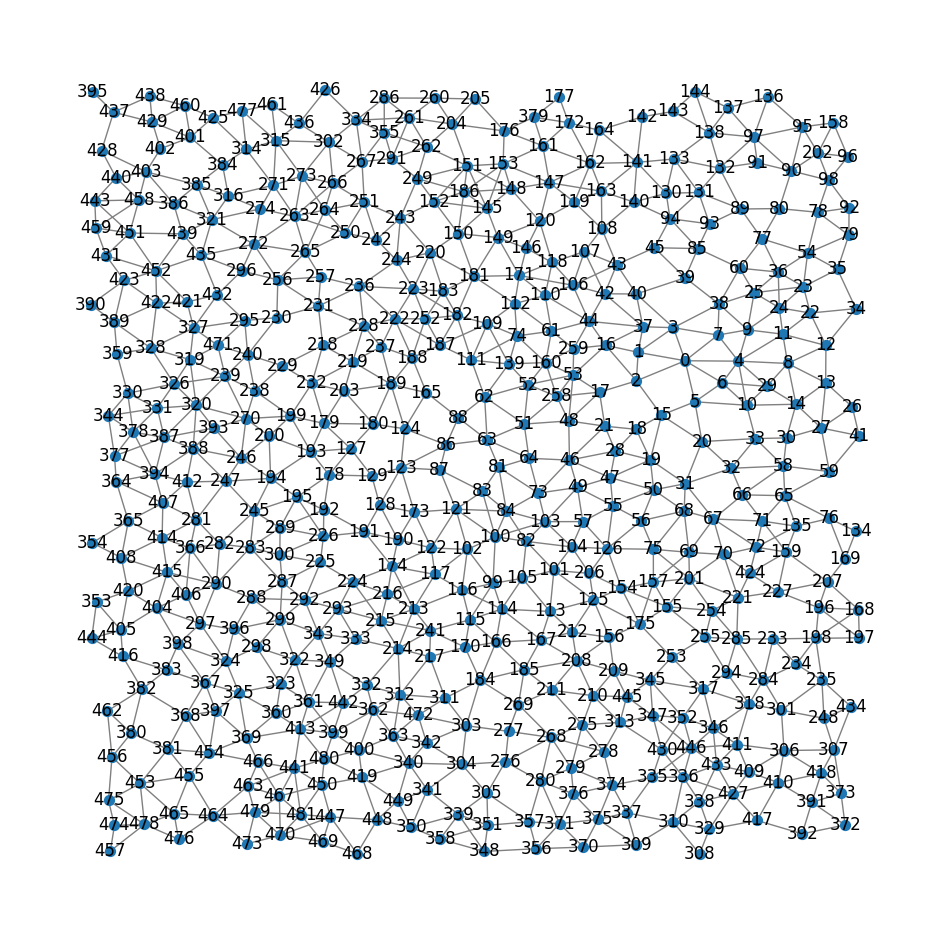

In [20]:
%matplotlib inline
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch_geometric as pyg
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx


def analyze_graph(G):
    # Analyze directionality
    is_directed = nx.is_directed(G)
    print(f"Graph is {'directed' if is_directed else 'undirected'}.")

    # Degree distribution
    degree_distribution = [d for n, d in G.degree()]
    plt.hist(degree_distribution, bins=30)
    plt.title('Degree Distribution')
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.show()

    # Check for loops
    has_loops = nx.number_of_selfloops(G) > 0
    print(f"Graph has {'loops' if has_loops else 'no loops'}.")

    # Identify isolated nodes
    isolated_nodes = list(nx.isolates(G))
    print(f"Graph has {len(isolated_nodes)} isolated nodes.")

def visualize_graph(graph, position):
    G = to_networkx(graph, to_undirected=True)
    G.remove_edges_from(nx.selfloop_edges(G))
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    nx.draw_networkx(G,
                     pos={i: tuple(v) for i, v in enumerate(position)},
                     node_size=50,
                     edge_color="grey")
    plt.show()

# Analyze the graph
analyze_graph(G)

# Visualize the graph
visualize_graph(graph, position)

## Graph Neural Networks

In [21]:
import math
import torch_scatter

class MLP(torch.nn.Module):
    """Multi-Layer perceptron"""
    def __init__(self, input_size, hidden_size, output_size, layers, layernorm=True):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        for i in range(layers):
            self.layers.append(torch.nn.Linear(
                input_size if i == 0 else hidden_size,
                output_size if i == layers - 1 else hidden_size,
            ))
            if i != layers - 1:
                self.layers.append(torch.nn.ReLU())
        if layernorm:
            self.layers.append(torch.nn.LayerNorm(output_size))
        self.reset_parameters()

    def reset_parameters(self):
        for layer in self.layers:
            if isinstance(layer, torch.nn.Linear):
                layer.weight.data.normal_(0, 1 / math.sqrt(layer.in_features))
                layer.bias.data.fill_(0)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [22]:
import torch
import torch.nn.functional as F
import torch_scatter
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data


class InteractionNetwork(MessagePassing):
    def __init__(self, hidden_size, layers):
        super().__init__()
        self.lin_edge = MLP(hidden_size * 3, hidden_size, hidden_size, layers)
        self.lin_node = MLP(hidden_size * 2, hidden_size, hidden_size, layers)

    def forward(self, x, edge_index, edge_feature):
        edge_out, aggr = self.propagate(edge_index, x=(x, x), edge_feature=edge_feature)
        node_out = self.lin_node(torch.cat((x, aggr), dim=-1))
        edge_out = edge_feature + edge_out
        node_out = x + node_out
        return node_out, edge_out

    def message(self, x_i, x_j, edge_feature):
        x = torch.cat((x_i, x_j, edge_feature), dim=-1)
        x = self.lin_edge(x)
        return x

    def aggregate(self, inputs, index, dim_size=None):
        out = torch_scatter.scatter(inputs, index, dim=self.node_dim, dim_size=dim_size, reduce="sum")
        return (inputs, out)


## Task Implementation (Task 3)

In [23]:

class LearnedSimulator(torch.nn.Module):
    """Graph Network-based Simulators(GNS)"""
    def __init__(
        self,
        hidden_size=128,
        n_mp_layers=10, # number of GNN layers
        num_particle_types=9,
        particle_type_dim=16, # embedding dimension of particle types
        dim=2, # dimension of the world, typical 2D or 3D
        window_size=5, # the model looks into W frames before the frame to be predicted
    ):
        super().__init__()
        self.window_size = window_size
        self.embed_type = torch.nn.Embedding(num_particle_types, particle_type_dim)
        self.node_in = MLP(particle_type_dim + dim * (window_size + 2), hidden_size, hidden_size, 3)
        self.edge_in = MLP(dim + 1, hidden_size, hidden_size, 3)
        self.node_out = MLP(hidden_size, hidden_size, dim, 3, layernorm=False)
        self.n_mp_layers = n_mp_layers
        self.layers = torch.nn.ModuleList([InteractionNetwork(
            hidden_size, 3
        ) for _ in range(n_mp_layers)])

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.embed_type.weight)

    def forward(self, data):
        # pre-processing
        # node feature: combine categorical feature data.x and contiguous feature data.pos.
        node_feature = torch.cat((self.embed_type(data.x), data.pos), dim=-1)
        node_feature = self.node_in(node_feature)
        edge_feature = self.edge_in(data.edge_attr)
        # stack of GNN layers
        for i in range(self.n_mp_layers):
            node_feature, edge_feature = self.layers[i](node_feature, data.edge_index, edge_feature=edge_feature)
        # post-processing
        out = self.node_out(node_feature)
        return out


In [47]:
from torch_geometric.data import Data, DataLoader
from tqdm import tqdm
# Ensure the required directories exist
data_path = OUTPUT_DIR
model_path = os.path.join("temp", "models", DATASET_NAME)
rollout_path = os.path.join("temp", "rollouts", DATASET_NAME)
os.makedirs(model_path, exist_ok=True)
os.makedirs(rollout_path, exist_ok=True)

# Parameters for training
params = {
    "epoch": 1,
    "batch_size": 4,
    "lr": 1e-4,
    "noise": 3e-4,
    "save_interval": 1000,
    "eval_interval": 1000,
    "rollout_interval": 200000,
}

# Load dataset
train_dataset = OneStepDataset(data_path, "train", noise_std=params["noise"])
valid_dataset = OneStepDataset(data_path, "valid", noise_std=params["noise"])
train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True, pin_memory=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=params["batch_size"], shuffle=False, pin_memory=True, num_workers=2)
valid_rollout_dataset = RolloutDataset(data_path, "valid")

# Define the helper functions for evaluation
def rollout(model, data, metadata, noise_std):
    device = next(model.parameters()).device
    model.eval()
    window_size = model.window_size + 1
    total_time = data["position"].size(0)
    traj = data["position"][:window_size]
    traj = traj.permute(1, 0, 2)
    particle_type = data["particle_type"]

    for time in range(total_time - window_size):
        with torch.no_grad():
            graph = preprocess(particle_type, traj[:, -window_size:], None, metadata, 0.0)
            graph = graph.to(device)
            acceleration = model(graph).cpu()
            acceleration = acceleration * torch.sqrt(torch.tensor(metadata["acc_std"]) ** 2 + noise_std ** 2) + torch.tensor(metadata["acc_mean"])

            recent_position = traj[:, -1]
            recent_velocity = recent_position - traj[:, -2]
            new_velocity = recent_velocity + acceleration
            new_position = recent_position + new_velocity
            traj = torch.cat((traj, new_position.unsqueeze(1)), dim=1)

    return traj

def oneStepMSE(simulator, dataloader, metadata, noise):
    total_loss = 0.0
    total_mse = 0.0
    batch_count = 0
    simulator.eval()
    with torch.no_grad():
        scale = torch.sqrt(torch.tensor(metadata["acc_std"]) ** 2 + noise ** 2).cuda()
        for data in dataloader:
            data = data.cuda()
            pred = simulator(data)
            mse = ((pred - data.y) * scale) ** 2
            mse = mse.sum(dim=-1).mean()
            loss = ((pred - data.y) ** 2).mean()
            total_mse += mse.item()
            total_loss += loss.item()
            batch_count += 1
    return total_loss / batch_count, total_mse / batch_count

def rolloutMSE(simulator, dataset, noise):
    total_loss = 0.0
    batch_count = 0
    simulator.eval()
    with torch.no_grad():
        for rollout_data in dataset:
            rollout_out = rollout(simulator, rollout_data, dataset.metadata, noise)
            rollout_out = rollout_out.permute(1, 0, 2)
            loss = (rollout_out - rollout_data["position"]) ** 2
            loss = loss.sum(dim=-1).mean()
            total_loss += loss.item()
            batch_count += 1
    return total_loss / batch_count

In [28]:


# Training function
def train(params, simulator, train_loader, valid_loader, valid_rollout_dataset):
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(simulator.parameters(), lr=params["lr"])
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1 ** (1 / 5e6))

    train_loss_list = []
    eval_loss_list = []
    onestep_mse_list = []
    rollout_mse_list = []
    total_step = 0

    for i in range(params["epoch"]):
        simulator.train()
        progress_bar = tqdm(train_loader, desc=f"Epoch {i}")
        total_loss = 0
        batch_count = 0
        for data in progress_bar:
            optimizer.zero_grad()
            data = data.cuda()
            pred = simulator(data)
            loss = loss_fn(pred, data.y)
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
            batch_count += 1
            progress_bar.set_postfix({"loss": loss.item(), "avg_loss": total_loss / batch_count, "lr": optimizer.param_groups[0]["lr"]})
            total_step += 1
            train_loss_list.append((total_step, loss.item()))

            if total_step % params["eval_interval"] == 0:
                simulator.eval()
                eval_loss, onestep_mse = oneStepMSE(simulator, valid_loader, valid_dataset.metadata, params["noise"])
                eval_loss_list.append((total_step, eval_loss))
                onestep_mse_list.append((total_step, onestep_mse))
                tqdm.write(f"\nEval: Loss: {eval_loss}, One Step MSE: {onestep_mse}")
                simulator.train()

            if total_step % params["rollout_interval"] == 0:
                simulator.eval()
                rollout_mse = rolloutMSE(simulator, valid_rollout_dataset, params["noise"])
                rollout_mse_list.append((total_step, rollout_mse))
                tqdm.write(f"\nEval: Rollout MSE: {rollout_mse}")
                simulator.train()

            if total_step % params["save_interval"] == 0:
                torch.save(
                    {
                        "model": simulator.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "scheduler": scheduler.state_dict(),
                    },
                    os.path.join(model_path, f"checkpoint_{total_step}.pt")
                )
    return train_loss_list, eval_loss_list, onestep_mse_list, rollout_mse_list


model = LearnedSimulator().cuda()

# Train the model
train_loss_list, eval_loss_list, onestep_mse_list, rollout_mse_list = train(params, model, train_loader, valid_loader, valid_rollout_dataset)


Epoch 0:   4%|▍         | 1002/24875 [00:37<5:08:10,  1.29it/s, loss=0.936, avg_loss=1.01, lr=0.0001]


Eval: Loss: 0.9493996451138683, One Step MSE: 1.8232057987531124e-07


Epoch 0:   8%|▊         | 2004/24875 [01:14<3:54:33,  1.63it/s, loss=1.09, avg_loss=1, lr=9.99e-5]   


Eval: Loss: 0.9411235227941317, One Step MSE: 1.8072430648245813e-07


Epoch 0:  12%|█▏        | 3004/24875 [01:52<4:06:38,  1.48it/s, loss=0.39, avg_loss=0.902, lr=9.99e-5] 


Eval: Loss: 0.34796466448395197, One Step MSE: 6.691638312843173e-08


Epoch 0:  16%|█▌        | 4002/24875 [02:29<4:31:02,  1.28it/s, loss=0.172, avg_loss=0.758, lr=9.98e-5]


Eval: Loss: 0.2504128820331725, One Step MSE: 4.811455685747149e-08


Epoch 0:  20%|██        | 5005/24875 [03:07<3:11:56,  1.73it/s, loss=0.152, avg_loss=0.658, lr=9.98e-5]


Eval: Loss: 0.20498021923221194, One Step MSE: 3.9337673651543576e-08


Epoch 0:  24%|██▍       | 6004/24875 [03:45<3:07:35,  1.68it/s, loss=0.139, avg_loss=0.587, lr=9.97e-5]


Eval: Loss: 0.16167685936333856, One Step MSE: 3.101648182735062e-08


Epoch 0:  28%|██▊       | 7003/24875 [04:23<4:19:46,  1.15it/s, loss=0.136, avg_loss=0.533, lr=9.97e-5]


Eval: Loss: 0.14557210970490309, One Step MSE: 2.7913400001557768e-08


Epoch 0:  32%|███▏      | 8005/24875 [05:01<3:24:16,  1.38it/s, loss=0.256, avg_loss=0.49, lr=9.96e-5]  


Eval: Loss: 0.14067562585666632, One Step MSE: 2.6992555564770923e-08


Epoch 0:  36%|███▌      | 9004/24875 [05:40<2:44:58,  1.60it/s, loss=0.191, avg_loss=0.455, lr=9.96e-5]


Eval: Loss: 0.1291853166469807, One Step MSE: 2.4757492504096573e-08


Epoch 0:  40%|████      | 10002/24875 [06:18<3:23:50,  1.22it/s, loss=0.191, avg_loss=0.427, lr=9.95e-5]


Eval: Loss: 0.17807741706945313, One Step MSE: 3.4078476782189024e-08


Epoch 0:  44%|████▍     | 11003/24875 [06:55<3:08:37,  1.23it/s, loss=0.187, avg_loss=0.403, lr=9.95e-5] 


Eval: Loss: 0.11713855082941783, One Step MSE: 2.2460506097371546e-08


Epoch 0:  48%|████▊     | 12004/24875 [07:33<2:05:54,  1.70it/s, loss=0.125, avg_loss=0.385, lr=9.94e-5] 


Eval: Loss: 0.11742295321807793, One Step MSE: 2.252539666617411e-08


Epoch 0:  52%|█████▏    | 13004/24875 [08:11<2:10:37,  1.51it/s, loss=0.46, avg_loss=0.368, lr=9.94e-5]  


Eval: Loss: 0.4132920110005274, One Step MSE: 7.976325026694305e-08


Epoch 0:  56%|█████▋    | 14003/24875 [08:49<2:21:31,  1.28it/s, loss=0.104, avg_loss=0.353, lr=9.94e-5]


Eval: Loss: 0.1315875433211685, One Step MSE: 2.5299930579975234e-08


Epoch 0:  60%|██████    | 15003/24875 [09:27<2:21:06,  1.17it/s, loss=0.136, avg_loss=0.339, lr=9.93e-5] 


Eval: Loss: 0.11437796755511181, One Step MSE: 2.192382596652469e-08


Epoch 0:  64%|██████▍   | 16003/24875 [10:05<2:12:39,  1.11it/s, loss=0.164, avg_loss=0.328, lr=9.93e-5] 


Eval: Loss: 0.10529942084942312, One Step MSE: 2.0209047511531016e-08


Epoch 0:  68%|██████▊   | 17001/24875 [10:43<2:02:22,  1.07it/s, loss=0.15, avg_loss=0.317, lr=9.92e-5]  


Eval: Loss: 0.1453501440680487, One Step MSE: 2.7899436398864924e-08


Epoch 0:  72%|███████▏  | 18004/24875 [11:21<1:14:46,  1.53it/s, loss=0.12, avg_loss=0.308, lr=9.92e-5]  


Eval: Loss: 0.10496317599136443, One Step MSE: 2.014071432890314e-08


Epoch 0:  76%|███████▋  | 19004/24875 [12:00<59:43,  1.64it/s, loss=0.177, avg_loss=0.299, lr=9.91e-5]  


Eval: Loss: 0.1754472068424106, One Step MSE: 3.37714329941522e-08


Epoch 0:  80%|████████  | 20004/24875 [12:38<55:04,  1.47it/s, loss=0.154, avg_loss=0.29, lr=9.91e-5]   


Eval: Loss: 0.0946861015530932, One Step MSE: 1.816244048048794e-08


Epoch 0:  84%|████████▍ | 21001/24875 [13:16<56:00,  1.15it/s, loss=0.149, avg_loss=0.283, lr=9.9e-5]  


Eval: Loss: 0.12742861231543434, One Step MSE: 2.4438552513565778e-08


Epoch 0:  88%|████████▊ | 22003/24875 [13:54<42:14,  1.13it/s, loss=0.0895, avg_loss=0.276, lr=9.9e-5]


Eval: Loss: 0.09073048479064484, One Step MSE: 1.73928220032873e-08


Epoch 0:  92%|█████████▏| 23000/24875 [14:32<27:05,  1.15it/s, loss=0.115, avg_loss=0.269, lr=9.89e-5] 


Eval: Loss: 0.087446056330319, One Step MSE: 1.6766953109955695e-08


Epoch 0:  96%|█████████▋| 24004/24875 [15:10<08:35,  1.69it/s, loss=0.056, avg_loss=0.263, lr=9.89e-5] 


Eval: Loss: 0.08767781731855256, One Step MSE: 1.6816507853258437e-08


Epoch 0: 100%|██████████| 24875/24875 [15:31<00:00, 26.69it/s, loss=0.0751, avg_loss=0.258, lr=9.89e-5]


## Visualization

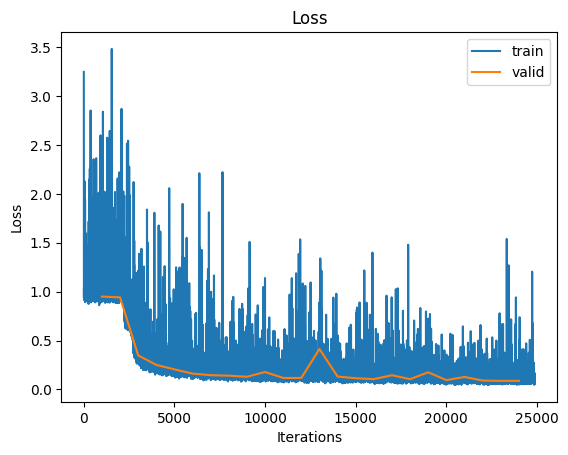

In [29]:

# Visualize the loss curve
plt.figure()
plt.plot(*zip(*train_loss_list), label="train")
plt.plot(*zip(*eval_loss_list), label="valid")
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

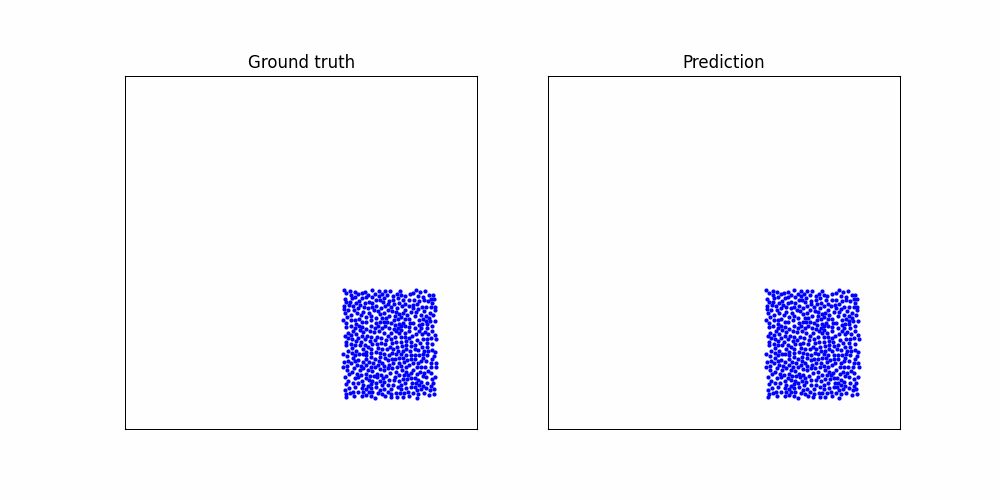

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from PIL import Image

TYPE_TO_COLOR = {
    3: "black",
    0: "green",
    7: "magenta",
    6: "gold",
    5: "blue",
}


def visualize_prepare(ax, particle_type, position, metadata):
    bounds = metadata["bounds"]
    ax.set_xlim(bounds[0][0], bounds[0][1])
    ax.set_ylim(bounds[1][0], bounds[1][1])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect(1.0)
    points = {type_: ax.plot([], [], "o", ms=2, color=color)[0] for type_, color in TYPE_TO_COLOR.items()}
    return ax, position, points


def visualize_pair(particle_type, position_pred, position_gt, metadata):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    plot_info = [
        visualize_prepare(axes[0], particle_type, position_gt, metadata),
        visualize_prepare(axes[1], particle_type, position_pred, metadata),
    ]
    axes[0].set_title("Ground truth")
    axes[1].set_title("Prediction")

    plt.close()

    def update(step_i):
        outputs = []
        for _, position, points in plot_info:
            for type_, line in points.items():
                mask = particle_type == type_
                line.set_data(position[step_i, mask, 0], position[step_i, mask, 1])
            outputs.append(line)
        return outputs

    ani = animation.FuncAnimation(fig, update, frames=np.arange(0, position_gt.shape[0]), interval=10, blit=True)
    ani.save("animation.gif", writer="pillow", fps=10)
    return ani

# Assuming the necessary imports and definitions for RolloutDataset and the model are already made
# Example usage with the actual rollout data

rollout_dataset = RolloutDataset(data_path, "valid")
model.eval()
rollout_data = rollout_dataset[0]
rollout_out = rollout(model, rollout_data, rollout_dataset.metadata, params["noise"])
rollout_out = rollout_out.permute(1, 0, 2)  # Adjusting the shape as required

particle_type = rollout_data["particle_type"].numpy()  # Assuming rollout_data has particle_type in numpy format
position_gt = rollout_data["position"].numpy()  # Assuming rollout_data has position in numpy format

# Generate the animation
anim = visualize_pair(particle_type, rollout_out.numpy(), position_gt, rollout_dataset.metadata)


# If you want to display the GIF in the notebook
from IPython.display import Image as IPImage
IPImage(filename="animation.gif")
